In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [2]:
# Ignore future warnings
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

In [3]:
def load_and_test_data():
    """Load and test the preprocessed rice dataset"""
    try:
        # Load the preprocessed rice dataset
        data = pd.read_csv('pre_processed_rice-final2.csv')

        # Separate features and target, ensuring proper data types
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values

        print(f'Dataset loaded successfully!')
        print(f'Dataset shape: {X.shape}')
        print(f'Number of classes: {len(np.unique(y))}')
        print(f'Class distribution: {np.bincount(y)}')
        print(f'Feature range: [{X.min():.4f}, {X.max():.4f}]')
        print(f'Target classes: {np.unique(y)}')

        return X, y
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

In [4]:
# Load data
X, y = load_and_test_data()

Dataset loaded successfully!
Dataset shape: (1400, 7)
Number of classes: 2
Class distribution: [600 800]
Feature range: [0.0000, 1.0000]
Target classes: [0 1]


In [5]:
# Set up 10-fold stratified cross-validation
cvKFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Parameters for classifiers
bag_n_estimators = 50
bag_max_samples = 100
bag_max_depth = 5

ada_n_estimators = 50
ada_learning_rate = 0.5
ada_bag_max_depth = 5

In [6]:
# Decision Tree
def dtClassifier(X, y):
    dt_classifier = DecisionTreeClassifier(random_state=0)
    scores = cross_val_score(dt_classifier, X, y, cv=cvKFold, scoring='accuracy')
    return scores.mean()

In [8]:
def bagDTClassifier(X, y, n_estimators, max_samples, max_depth):
    base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    bag_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=max_samples,
        random_state=0
    )
    scores = cross_val_score(bag_classifier, X, y, cv=cvKFold, scoring='accuracy')
    return scores.mean()

In [9]:
def adaDTClassifier(X, y, n_estimators, learning_rate, max_depth):
    base_estimator_ada = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    ada_classifier = AdaBoostClassifier(
        estimator=base_estimator_ada,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=0,
        algorithm='SAMME'
    )
    scores = cross_val_score(ada_classifier, X, y, cv=cvKFold, scoring='accuracy')
    return scores.mean()

In [12]:
dt_scores = dtClassifier(X, y)
bag_scores = bagDTClassifier(X, y, bag_n_estimators, bag_max_samples, bag_max_depth)
ada_scores = adaDTClassifier(X, y, ada_n_estimators, ada_learning_rate, ada_bag_max_depth)
print(f'DT average cross-validation accuracy:: {dt_scores:.4f}')
print(f"Bagging average cross-validation accuracy: {bag_scores:.4f}")
print(f"AdaBoost average cross-validation accuracy: {ada_scores:.4f}")

DT average cross-validation accuracy:: 0.9057
Bagging average cross-validation accuracy: 0.9421
AdaBoost average cross-validation accuracy: 0.9307


In [13]:
# Quick performance comparison
results = {
    'Decision Tree': dt_scores,
    'Bagging': bag_scores,
    'AdaBoost': ada_scores
}

best_classifier = max(results, key=results.get)
print(f"\nBest performing classifier: {best_classifier} ({results[best_classifier]:.4f})")


Best performing classifier: Bagging (0.9421)


In [14]:
# Generate visualizations and detailed analysis
# Initialize classifiers with same parameters
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Bagging': BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=bag_max_depth, random_state=0),
        n_estimators=bag_n_estimators,
        max_samples=bag_max_samples,
        random_state=0
    ),
    'AdaBoost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=ada_bag_max_depth, random_state=0),
        n_estimators=ada_n_estimators,
        learning_rate=ada_learning_rate,
        random_state=0,
        algorithm='SAMME'
    )
}

In [16]:
# Collect detailed performance metrics
all_results = []
for name, clf in classifiers.items():
    # Collect cross-validation scores for each fold
    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1_scores = []
    all_y_true = []
    all_y_pred = []

    # Perform stratified k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(cvKFold.split(X, y)):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Train classifier on current fold
        clf.fit(X_train_fold, y_train_fold)

        # Make predictions on test set
        y_pred_fold = clf.predict(X_test_fold)

        # Store true and predicted labels for confusion matrix
        all_y_true.extend(y_test_fold)
        all_y_pred.extend(y_pred_fold)

        # Calculate metrics for current fold
        accuracy = accuracy_score(y_test_fold, y_pred_fold)
        precision = precision_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)
        recall = recall_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, average='weighted', zero_division=0)

        # Store metrics
        cv_accuracies.append(accuracy)
        cv_precisions.append(precision)
        cv_recalls.append(recall)
        cv_f1_scores.append(f1)

    # Store results
    result = {
        'classifier_name': name,
        'accuracy_mean': np.mean(cv_accuracies),
        'accuracy_std': np.std(cv_accuracies),
        'precision_mean': np.mean(cv_precisions),
        'precision_std': np.std(cv_precisions),
        'recall_mean': np.mean(cv_recalls),
        'recall_std': np.std(cv_recalls),
        'f1_mean': np.mean(cv_f1_scores),
        'f1_std': np.std(cv_f1_scores),
        'cv_accuracies': cv_accuracies,
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred
    }
    all_results.append(result)

for result in all_results:
    print(f'\n{result["classifier_name"]} Classifier:')
    print('-' * 50)
    print(f'Accuracy:  {result["accuracy_mean"]:.4f} ± {result["accuracy_std"]:.4f}')
    print(f'Precision: {result["precision_mean"]:.4f} ± {result["precision_std"]:.4f}')
    print(f'Recall:    {result["recall_mean"]:.4f} ± {result["recall_std"]:.4f}')
    print(f'F1-Score:  {result["f1_mean"]:.4f} ± {result["f1_std"]:.4f}')


Decision Tree Classifier:
--------------------------------------------------
Accuracy:  0.9057 ± 0.0204
Precision: 0.9068 ± 0.0199
Recall:    0.9057 ± 0.0204
F1-Score:  0.9058 ± 0.0202

Bagging Classifier:
--------------------------------------------------
Accuracy:  0.9421 ± 0.0215
Precision: 0.9430 ± 0.0214
Recall:    0.9421 ± 0.0215
F1-Score:  0.9421 ± 0.0215

AdaBoost Classifier:
--------------------------------------------------
Accuracy:  0.9307 ± 0.0230
Precision: 0.9314 ± 0.0231
Recall:    0.9307 ± 0.0230
F1-Score:  0.9307 ± 0.0229


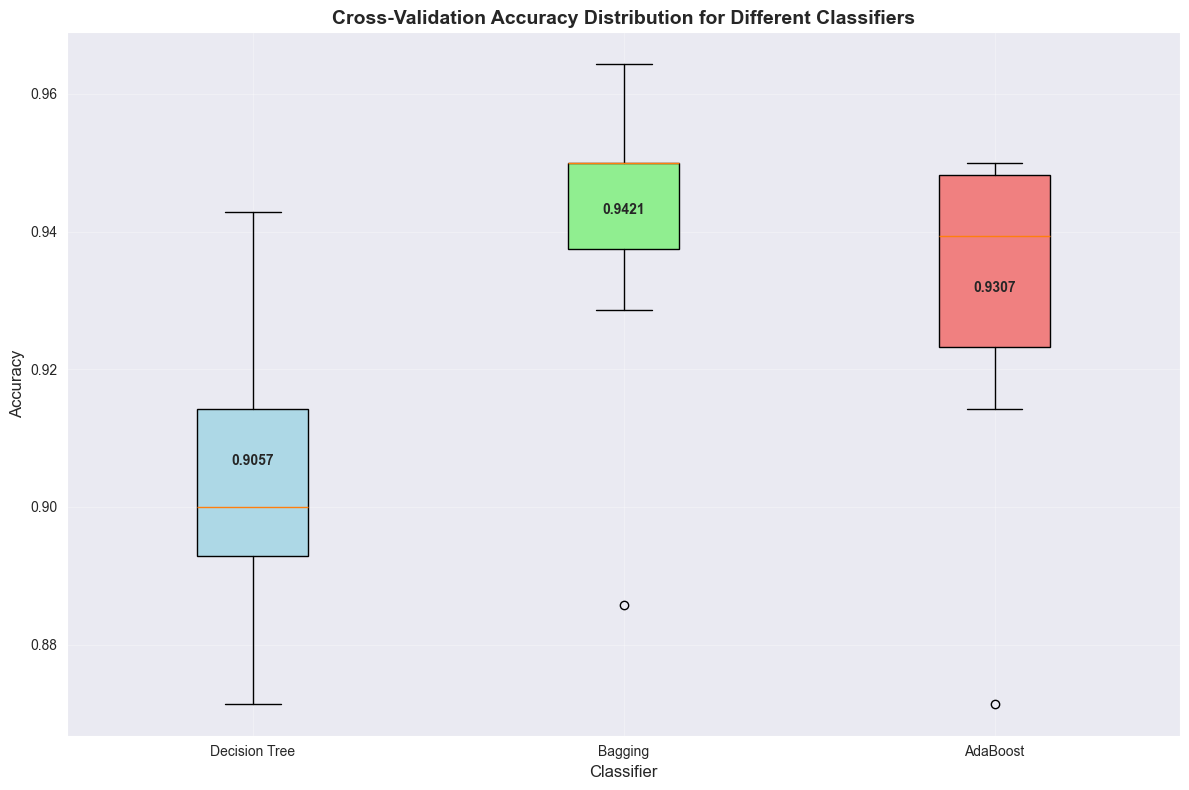

In [17]:
# Create visualizations
# Boxplot for cross-validation accuracies
plt.figure(figsize=(12, 8), dpi=100)

accuracy_data = [result['cv_accuracies'] for result in all_results]
classifier_names = [result['classifier_name'] for result in all_results]

box_plot = plt.boxplot(accuracy_data, labels=classifier_names, patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Cross-Validation Accuracy Distribution for Different Classifiers',
          fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Classifier', fontsize=12)
plt.grid(True, alpha=0.3)

# Add mean accuracy values as text
for i, result in enumerate(all_results):
    plt.text(i + 1, result['accuracy_mean'], f'{result["accuracy_mean"]:.4f}',
             horizontalalignment='center', verticalalignment='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

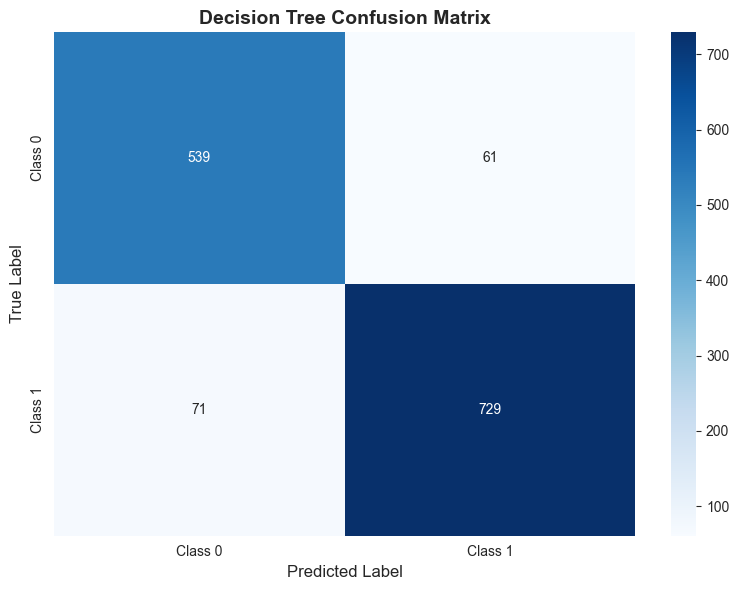

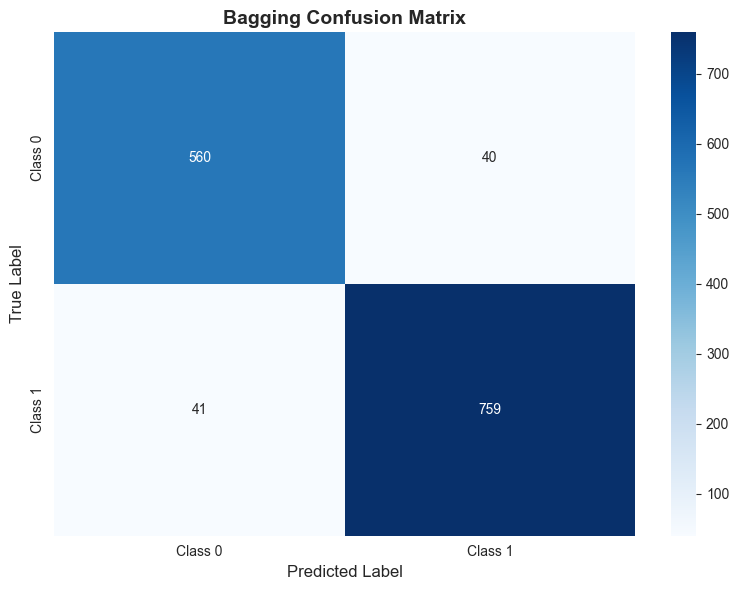

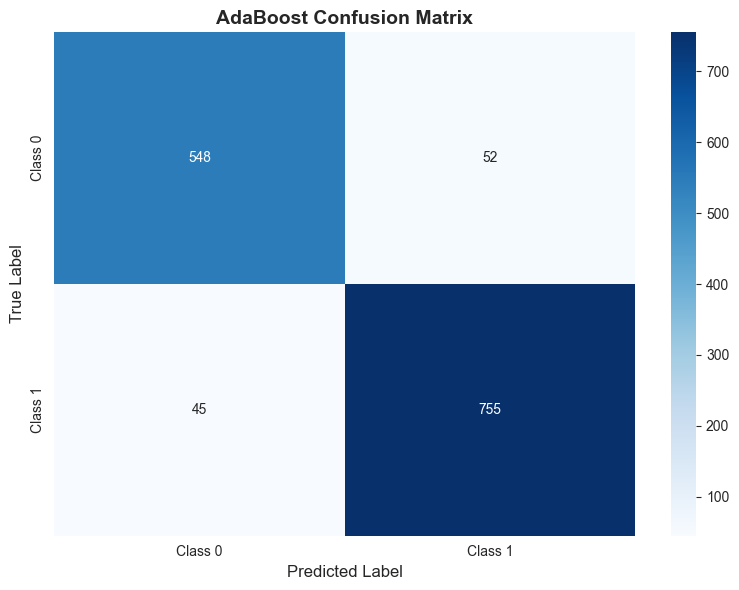

In [18]:
# Individual Confusion matrices
for i, result in enumerate(all_results):
    plt.figure(figsize=(8, 6), dpi=100)

    # Calculate confusion matrix
    cm = confusion_matrix(result['all_y_true'], result['all_y_pred'])

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])

    plt.title(f'{result["classifier_name"]} Confusion Matrix', fontweight='bold', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)

    plt.tight_layout()
    plt.show()

In [19]:
# Parameter sensitivity analysis
print('\nPerforming parameter sensitivity analysis...')

# Decision Tree max_depth sensitivity
dt_max_depths = [3, 5, 10, 15, 20, None]
dt_depth_scores = []

print('\nDecision Tree max_depth sensitivity:')
for depth in dt_max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=0)
    scores = cross_val_score(dt_temp, X, y, cv=cvKFold, scoring='accuracy')
    mean_score = scores.mean()
    dt_depth_scores.append(mean_score)
    print(f'max_depth={depth}: {mean_score:.4f}')


Performing parameter sensitivity analysis...

Decision Tree max_depth sensitivity:
max_depth=3: 0.9414
max_depth=5: 0.9293
max_depth=10: 0.9136
max_depth=15: 0.9057
max_depth=20: 0.9057
max_depth=None: 0.9057


In [20]:
# Bagging n_estimators sensitivity
bag_n_estimators_range = [10, 25, 50, 75, 100]
bag_estimator_scores = []

print('\nBagging n_estimators sensitivity:')
for n_est in bag_n_estimators_range:
    bag_temp = BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=bag_max_depth, random_state=0),
        n_estimators=n_est,
        max_samples=bag_max_samples,
        random_state=0
    )
    scores = cross_val_score(bag_temp, X, y, cv=cvKFold, scoring='accuracy')
    mean_score = scores.mean()
    bag_estimator_scores.append(mean_score)
    print(f'n_estimators={n_est}: {mean_score:.4f}')


Bagging n_estimators sensitivity:
n_estimators=10: 0.9407
n_estimators=25: 0.9414
n_estimators=50: 0.9421
n_estimators=75: 0.9414
n_estimators=100: 0.9421


In [21]:
# AdaBoost learning_rate sensitivity
ada_learning_rates = [0.1, 0.3, 0.5, 0.7, 1.0]
ada_lr_scores = []

print('\nAdaBoost learning_rate sensitivity:')
for lr in ada_learning_rates:
    ada_temp = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=ada_bag_max_depth, random_state=0),
        n_estimators=ada_n_estimators,
        learning_rate=lr,
        random_state=0,
        algorithm='SAMME'
    )
    scores = cross_val_score(ada_temp, X, y, cv=cvKFold, scoring='accuracy')
    mean_score = scores.mean()
    ada_lr_scores.append(mean_score)
    print(f'learning_rate={lr}: {mean_score:.4f}')


AdaBoost learning_rate sensitivity:
learning_rate=0.1: 0.9371
learning_rate=0.3: 0.9364
learning_rate=0.5: 0.9307
learning_rate=0.7: 0.9307
learning_rate=1.0: 0.9293


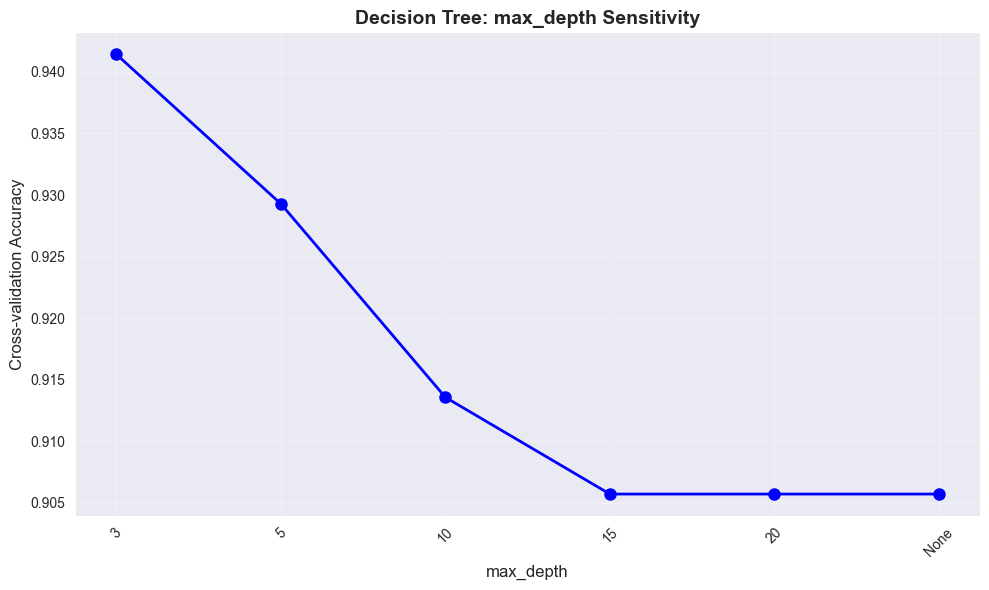

In [23]:
# Decision Tree max_depth sensitivity plot
plt.figure(figsize=(10, 6), dpi=100)
plt.plot([str(d) for d in dt_max_depths], dt_depth_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Decision Tree: max_depth Sensitivity', fontweight='bold', fontsize=14)
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('Cross-validation Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

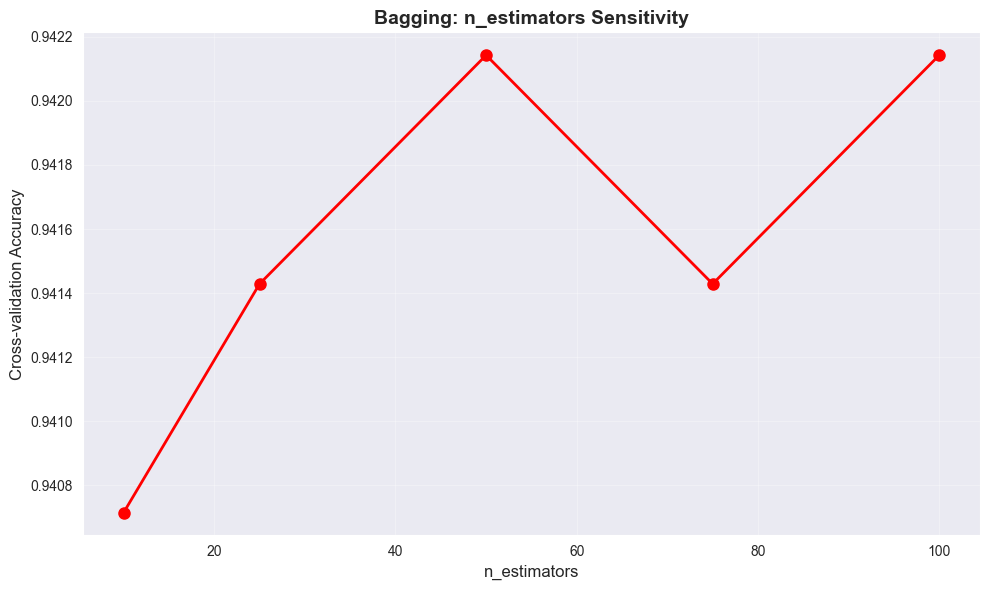

In [26]:
# Bagging n_estimators sensitivity plot
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(bag_n_estimators_range, bag_estimator_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Bagging: n_estimators Sensitivity', fontweight='bold', fontsize=14)
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('Cross-validation Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

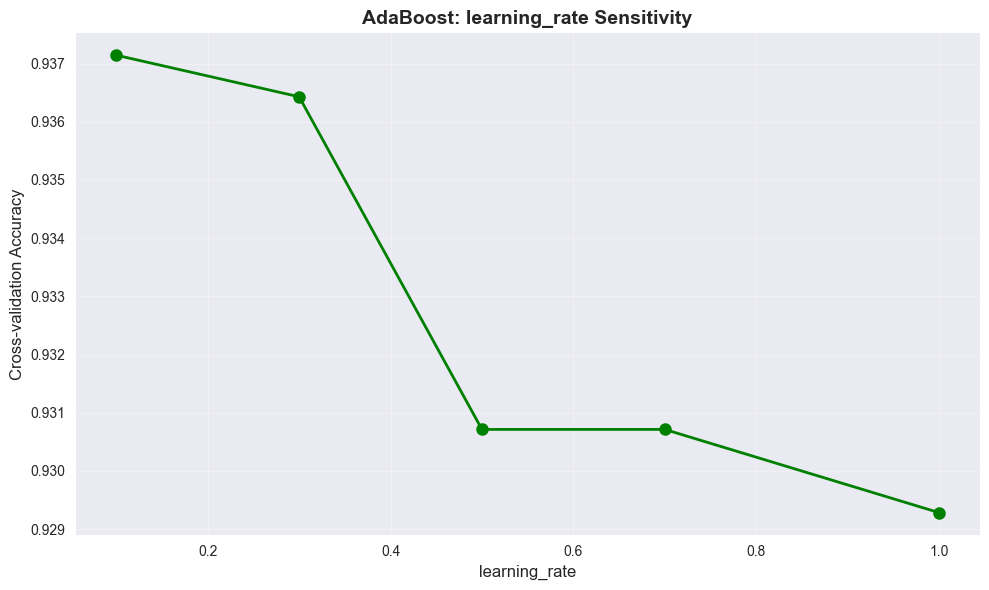

In [27]:
# AdaBoost learning_rate sensitivity plot
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(ada_learning_rates, ada_lr_scores, 'go-', linewidth=2, markersize=8)
plt.title('AdaBoost: learning_rate Sensitivity', fontweight='bold', fontsize=14)
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('Cross-validation Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()